# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from catboost import CatBoostClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 데이터 읽어오기


In [2]:
ROOT_DIR = "data"
random_seed = 110

# Load data
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
test_data = test_data[train_data.columns]
train_data.head()

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


In [3]:
# mixed_columns = [
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam",
#     "Stage1 Circle1 Distance Speed Collect Result_Dam",
#     "THICKNESS 1 Collect Result_Dam",
#     "WorkMode Collect Result_Dam",
#     "GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave",
#     "GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2"
# ]

# train_data = train_data.drop(mixed_columns, axis=1)
# test_data = test_data.drop(mixed_columns, axis=1)

In [4]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

def perform_minibatch_kmeans_clustering(data, n_clusters=3, batch_size=100):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42)
    return kmeans.fit_predict(data)

def apply_minibatch_kmeans_clustering_to_data(train_data, test_data, feature_columns, n_clusters=3, batch_size=100):
    scaler = StandardScaler()

    # 훈련 데이터에 대해 클러스터링
    train_data_scaled = scaler.fit_transform(train_data[feature_columns].dropna())
    train_labels = perform_minibatch_kmeans_clustering(train_data_scaled, n_clusters, batch_size)
    train_labels = train_labels.astype(str)
    
    # 테스트 데이터에 대해 동일한 스케일링 적용 후 클러스터링
    test_data_scaled = scaler.transform(test_data[feature_columns].dropna())
    test_labels = perform_minibatch_kmeans_clustering(test_data_scaled, n_clusters, batch_size)
    test_labels = test_labels.astype(str)
    
    return train_labels, test_labels

# 클러스터링 적용: Cure Start Position
cure_start_columns = ['CURE START POSITION X Collect Result_Dam', 'CURE START POSITION Z Collect Result_Dam']
train_data['CURE_START_CLUSTER'], test_data['CURE_START_CLUSTER'] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, cure_start_columns, n_clusters=2)

# 클러스터링 적용: Cure Standby Position
cure_standby_columns = ['CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam']
train_data['CURE_STANDBY_CLUSTER'], test_data['CURE_STANDBY_CLUSTER'] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, cure_standby_columns, n_clusters=1)

# 클러스터링 적용: Cure End Position
cure_end_columns = ['CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam']
train_data['CURE_END_CLUSTER'], test_data['CURE_END_CLUSTER'] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, cure_end_columns, n_clusters=2)

# 클러스터링 적용: Head Standby Position
head_standby_columns = ['HEAD Standby Position X Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Dam']
train_data['HEAD_STANDBY_CLUSTER'], test_data['HEAD_STANDBY_CLUSTER'] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, head_standby_columns, n_clusters=3)

# 클러스터링 적용: Head Clean Position
head_clean_columns = ['Head Clean Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam', 'Head Clean Position Z Collect Result_Dam']
train_data['HEAD_CLEAN_CLUSTER'], test_data['HEAD_CLEAN_CLUSTER'] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, head_clean_columns, n_clusters=2)

# 클러스터링 적용: Head Purge Position
head_purge_columns = ['Head Purge Position X Collect Result_Dam', 'Head Purge Position Y Collect Result_Dam', 'Head Purge Position Z Collect Result_Dam']
train_data['HEAD_PURGE_CLUSTER'], test_data['HEAD_PURGE_CLUSTER'] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, head_purge_columns, n_clusters=2)

# 클러스터링 적용: Head Zero Position
head_zero_columns = ['Head Zero Position X Collect Result_Dam', 'Head Zero Position Y Collect Result_Dam', 'Head Zero Position Z Collect Result_Dam']
train_data['HEAD_ZERO_CLUSTER'], test_data['HEAD_ZERO_CLUSTER'] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, head_zero_columns, n_clusters=2)

# 클러스터링 적용: Stage 2 Position
stage2_columns = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']
train_data['STAGE2_CLUSTER'], test_data['STAGE2_CLUSTER'] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, stage2_columns, n_clusters=6)

# 클러스터링 적용: Stage 3 Position
stage3_columns = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']
train_data['STAGE3_CLUSTER'], test_data['STAGE3_CLUSTER'] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, stage3_columns, n_clusters=5)


In [5]:
cure_cols = [
    'CURE_START_CLUSTER',
    'CURE_STANDBY_CLUSTER',
    'CURE_END_CLUSTER',
]
head_cols = [
    'HEAD_STANDBY_CLUSTER',
    'HEAD_CLEAN_CLUSTER',
    'HEAD_PURGE_CLUSTER',
    'HEAD_ZERO_CLUSTER',
]
stage_cols = [
    'STAGE2_CLUSTER',
    'STAGE3_CLUSTER',
]

target_cols = []
target_cols.extend(cure_cols)
target_cols.extend(head_cols)
target_cols.extend(stage_cols)

train_data['CURE_PROCESS'] = train_data['CURE_START_CLUSTER'] + '_' + train_data['CURE_STANDBY_CLUSTER'] + '_' + train_data['CURE_END_CLUSTER']
test_data['CURE_PROCESS'] = test_data['CURE_START_CLUSTER'] + '_' + test_data['CURE_STANDBY_CLUSTER'] + '_' + test_data['CURE_END_CLUSTER']

train_data['HEAD_PROCESS'] = train_data['HEAD_STANDBY_CLUSTER'] + '_' + train_data['HEAD_CLEAN_CLUSTER'] + '_' + train_data['HEAD_PURGE_CLUSTER'] + '_' + train_data['HEAD_ZERO_CLUSTER']
test_data['HEAD_PROCESS'] = test_data['HEAD_STANDBY_CLUSTER'] + '_' + test_data['HEAD_CLEAN_CLUSTER'] + '_' + test_data['HEAD_PURGE_CLUSTER'] + '_' + test_data['HEAD_ZERO_CLUSTER']

train_data['STAGE_PROCESS'] = train_data['STAGE2_CLUSTER'] + '_' + train_data['STAGE3_CLUSTER']
test_data['STAGE_PROCESS'] = test_data['STAGE2_CLUSTER'] + '_' + test_data['STAGE3_CLUSTER']

train_data = train_data.drop(target_cols, axis=1)
test_data = test_data.drop(target_cols, axis=1)

In [6]:
# 두 점 사이의 거리를 계산하는 함수
def calculate_distance(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

# 1. Head Standby -> Head Clean Distance
train_data['HEAD_Standby_to_Clean_Distance'] = calculate_distance(
    train_data['HEAD Standby Position X Collect Result_Dam'],
    train_data['HEAD Standby Position Y Collect Result_Dam'],
    train_data['HEAD Standby Position Z Collect Result_Dam'],
    train_data['Head Clean Position X Collect Result_Dam'],
    train_data['Head Clean Position Y Collect Result_Dam'],
    train_data['Head Clean Position Z Collect Result_Dam']
)

test_data['HEAD_Standby_to_Clean_Distance'] = calculate_distance(
    test_data['HEAD Standby Position X Collect Result_Dam'],
    test_data['HEAD Standby Position Y Collect Result_Dam'],
    test_data['HEAD Standby Position Z Collect Result_Dam'],
    test_data['Head Clean Position X Collect Result_Dam'],
    test_data['Head Clean Position Y Collect Result_Dam'],
    test_data['Head Clean Position Z Collect Result_Dam']
)

# 2. Head Clean -> Head Purge Distance
train_data['HEAD_Clean_to_Purge_Distance'] = calculate_distance(
    train_data['Head Clean Position X Collect Result_Dam'],
    train_data['Head Clean Position Y Collect Result_Dam'],
    train_data['Head Clean Position Z Collect Result_Dam'],
    train_data['Head Purge Position X Collect Result_Dam'],
    train_data['Head Purge Position Y Collect Result_Dam'],
    train_data['Head Purge Position Z Collect Result_Dam']
)

test_data['HEAD_Clean_to_Purge_Distance'] = calculate_distance(
    test_data['Head Clean Position X Collect Result_Dam'],
    test_data['Head Clean Position Y Collect Result_Dam'],
    test_data['Head Clean Position Z Collect Result_Dam'],
    test_data['Head Purge Position X Collect Result_Dam'],
    test_data['Head Purge Position Y Collect Result_Dam'],
    test_data['Head Purge Position Z Collect Result_Dam']
)

# 3. Head Purge -> Head Zero Distance
train_data['HEAD_Purge_to_Zero_Distance'] = calculate_distance(
    train_data['Head Purge Position X Collect Result_Dam'],
    train_data['Head Purge Position Y Collect Result_Dam'],
    train_data['Head Purge Position Z Collect Result_Dam'],
    train_data['Head Zero Position X Collect Result_Dam'],
    train_data['Head Zero Position Y Collect Result_Dam'],
    train_data['Head Zero Position Z Collect Result_Dam']
)

test_data['HEAD_Purge_to_Zero_Distance'] = calculate_distance(
    test_data['Head Purge Position X Collect Result_Dam'],
    test_data['Head Purge Position Y Collect Result_Dam'],
    test_data['Head Purge Position Z Collect Result_Dam'],
    test_data['Head Zero Position X Collect Result_Dam'],
    test_data['Head Zero Position Y Collect Result_Dam'],
    test_data['Head Zero Position Z Collect Result_Dam']
)

# 4. Head Standby -> Head Zero Distance (Direct)
train_data['HEAD_Standby_to_Zero_Distance'] = calculate_distance(
    train_data['HEAD Standby Position X Collect Result_Dam'],
    train_data['HEAD Standby Position Y Collect Result_Dam'],
    train_data['HEAD Standby Position Z Collect Result_Dam'],
    train_data['Head Zero Position X Collect Result_Dam'],
    train_data['Head Zero Position Y Collect Result_Dam'],
    train_data['Head Zero Position Z Collect Result_Dam']
)

test_data['HEAD_Standby_to_Zero_Distance'] = calculate_distance(
    test_data['HEAD Standby Position X Collect Result_Dam'],
    test_data['HEAD Standby Position Y Collect Result_Dam'],
    test_data['HEAD Standby Position Z Collect Result_Dam'],
    test_data['Head Zero Position X Collect Result_Dam'],
    test_data['Head Zero Position Y Collect Result_Dam'],
    test_data['Head Zero Position Z Collect Result_Dam']
)

# Cure 데이터의 거리 계산 (X와 Z 좌표 사용)

# 1. Cure Start -> Cure Standby Distance
train_data['CURE_Start_to_Standby_Distance'] = calculate_distance(
    train_data['CURE START POSITION X Collect Result_Dam'],
    np.zeros_like(train_data['CURE START POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    train_data['CURE START POSITION Z Collect Result_Dam'],
    train_data['CURE STANDBY POSITION X Collect Result_Dam'],
    np.zeros_like(train_data['CURE STANDBY POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    train_data['CURE STANDBY POSITION Z Collect Result_Dam']
)

test_data['CURE_Start_to_Standby_Distance'] = calculate_distance(
    test_data['CURE START POSITION X Collect Result_Dam'],
    np.zeros_like(test_data['CURE START POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    test_data['CURE START POSITION Z Collect Result_Dam'],
    test_data['CURE STANDBY POSITION X Collect Result_Dam'],
    np.zeros_like(test_data['CURE STANDBY POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    test_data['CURE STANDBY POSITION Z Collect Result_Dam']
)

# 2. Cure Standby -> Cure End Distance
train_data['CURE_Standby_to_End_Distance'] = calculate_distance(
    train_data['CURE STANDBY POSITION X Collect Result_Dam'],
    np.zeros_like(train_data['CURE STANDBY POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    train_data['CURE STANDBY POSITION Z Collect Result_Dam'],
    train_data['CURE END POSITION X Collect Result_Dam'],
    np.zeros_like(train_data['CURE END POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    train_data['CURE END POSITION Z Collect Result_Dam']
)

test_data['CURE_Standby_to_End_Distance'] = calculate_distance(
    test_data['CURE STANDBY POSITION X Collect Result_Dam'],
    np.zeros_like(test_data['CURE STANDBY POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    test_data['CURE STANDBY POSITION Z Collect Result_Dam'],
    test_data['CURE END POSITION X Collect Result_Dam'],
    np.zeros_like(test_data['CURE END POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    test_data['CURE END POSITION Z Collect Result_Dam']
)

# 3. Cure Start -> Cure End Distance (Direct)
train_data['CURE_Start_to_End_Distance'] = calculate_distance(
    train_data['CURE START POSITION X Collect Result_Dam'],
    np.zeros_like(train_data['CURE START POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    train_data['CURE START POSITION Z Collect Result_Dam'],
    train_data['CURE END POSITION X Collect Result_Dam'],
    np.zeros_like(train_data['CURE END POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    train_data['CURE END POSITION Z Collect Result_Dam']
)

test_data['CURE_Start_to_End_Distance'] = calculate_distance(
    test_data['CURE START POSITION X Collect Result_Dam'],
    np.zeros_like(test_data['CURE START POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    test_data['CURE START POSITION Z Collect Result_Dam'],
    test_data['CURE END POSITION X Collect Result_Dam'],
    np.zeros_like(test_data['CURE END POSITION X Collect Result_Dam']),  # Y 좌표는 0으로 설정
    test_data['CURE END POSITION Z Collect Result_Dam']
)

In [7]:
cols_to_drop = train_data.columns[train_data.nunique(dropna=False) == 1]
train_data = train_data.drop(cols_to_drop, axis=1)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 161 entries, Equipment_Dam to CURE_Start_to_End_Distance
dtypes: float64(75), int64(62), object(24)
memory usage: 49.8+ MB


In [9]:
object_columns = train_data.select_dtypes(include=['object']).columns.tolist()
train_data[object_columns]

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,Model.Suffix_AutoClave,Workorder_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,...,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1,Equipment_Fill2,Model.Suffix_Fill2,Workorder_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2,target,CURE_PROCESS,HEAD_PROCESS,STAGE_PROCESS
0,Dam dispenser #1,AJX75334505,4F1XA938-1,NaN,NaN,AJX75334505,4F1XA938-1,OK,NaN,NaN,...,NaN,Fill2 dispenser #1,AJX75334505,4F1XA938-1,NaN,NaN,Normal,0_0_0,0_0_0_0,4_3
1,Dam dispenser #1,AJX75334505,3KPM0016-2,550.3,NaN,AJX75334505,3KPM0016-2,OK,NaN,NaN,...,NaN,Fill2 dispenser #1,AJX75334505,3KPM0016-2,835.5,NaN,Normal,0_0_0,1_1_1_1,0_0
2,Dam dispenser #2,AJX75334501,4E1X9167-1,OK,OK,AJX75334501,4E1X9167-1,OK,OK,OK,...,OK,Fill2 dispenser #2,AJX75334501,4E1X9167-1,OK,OK,Normal,1_0_1,0_0_0_0,1_4
3,Dam dispenser #2,AJX75334501,3K1X0057-1,162.4,NaN,AJX75334501,3K1X0057-1,OK,NaN,NaN,...,NaN,Fill2 dispenser #2,AJX75334501,3K1X0057-1,305,NaN,Normal,1_0_1,1_1_1_1,3_1
4,Dam dispenser #1,AJX75334501,3HPM0007-1,549,NaN,AJX75334501,3HPM0007-1,NG,NaN,NaN,...,NaN,Fill2 dispenser #1,AJX75334501,3HPM0007-1,835.5,NaN,Normal,0_0_0,1_1_1_1,5_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,550.3,NaN,AJX75334501,3J1XF434-2,OK,NaN,NaN,...,NaN,Fill2 dispenser #1,AJX75334501,3J1XF434-2,835.5,NaN,Normal,0_0_0,1_1_1_1,0_0
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,NaN,NaN,AJX75334501,4E1XC796-1,NG,NaN,NaN,...,NaN,Fill2 dispenser #2,AJX75334501,4E1XC796-1,NaN,NaN,Normal,1_0_1,0_0_0_0,1_4
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,OK,OK,AJX75334501,4C1XD438-1,NG,OK,OK,...,OK,Fill2 dispenser #1,AJX75334501,4C1XD438-1,OK,OK,Normal,0_0_0,0_0_0_0,4_3
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,162.4,NaN,AJX75334501,3I1XA258-1,OK,NaN,NaN,...,NaN,Fill2 dispenser #2,AJX75334501,3I1XA258-1,305,NaN,Normal,1_0_1,1_1_1_1,3_1


In [10]:
model_cols = [
    'Model.Suffix_Dam',
    'Model.Suffix_AutoClave',
    'Model.Suffix_Fill1',
    'Model.Suffix_Fill2'
]

train_data['Model'] = train_data[model_cols[0]]
test_data['Model'] = test_data[model_cols[0]]

train_data = train_data.drop(model_cols, axis=1)
test_data = test_data.drop(model_cols, axis=1)

In [11]:
judge_cols = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
]

train_data['Judge'] = (train_data[judge_cols[0]]=='OK').replace({True: 1, False: 0})
test_data['Judge'] = (test_data[judge_cols[0]]=='OK').replace({True: 1, False: 0})

train_data = train_data.drop(judge_cols, axis=1)
test_data = test_data.drop(judge_cols, axis=1)

In [12]:
workorder_cols = [
    'Workorder_Dam',
    'Workorder_AutoClave',
    'Workorder_Fill1',
    'Workorder_Fill2',
]

train_data['Workorder'] = train_data[workorder_cols[0]]
test_data['Workorder'] = test_data[workorder_cols[0]]

train_data = train_data.drop(workorder_cols, axis=1)
test_data = test_data.drop(workorder_cols, axis=1)

In [13]:
train_data['Chamber Temp. Judge Value_AutoClave'] = (train_data['Chamber Temp. Judge Value_AutoClave']=="OK").replace({True: 1, False: 0})
test_data['Chamber Temp. Judge Value_AutoClave'] = (test_data['Chamber Temp. Judge Value_AutoClave'] == "OK").replace({True: 1, False: 0})

In [14]:
target_cols = [
    'Equipment_Dam',
    'Equipment_Fill1',
    'Equipment_Fill2',
]

train_data['Equipment'] = train_data['Equipment_Dam'] + '_' + train_data['Equipment_Fill1'] + '_' + train_data['Equipment_Fill2']
test_data['Equipment'] = test_data['Equipment_Dam'] + '_' + test_data['Equipment_Fill1'] + '_' + test_data['Equipment_Fill2']
train_data = train_data.drop(target_cols, axis=1)
test_data = test_data.drop(target_cols, axis=1)

In [15]:
drop_cols = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
]

train_data = train_data.drop(drop_cols, axis=1)
test_data = test_data.drop(drop_cols, axis=1)

In [16]:
# DataFrame에서 object 타입의 컬럼만 뽑아내기
object_columns = train_data.select_dtypes(include=['object']).columns.tolist()

# 추출된 컬럼들 출력
train_data[object_columns].head()

,target,CURE_PROCESS,HEAD_PROCESS,STAGE_PROCESS,Model,Workorder,Equipment
0,Normal,0_0_0,0_0_0_0,4_3,AJX75334505,4F1XA938-1,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
1,Normal,0_0_0,1_1_1_1,0_0,AJX75334505,3KPM0016-2,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
2,Normal,1_0_1,0_0_0_0,1_4,AJX75334501,4E1X9167-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...
3,Normal,1_0_1,1_1_1_1,3_1,AJX75334501,3K1X0057-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...
4,Normal,0_0_0,1_1_1_1,5_0,AJX75334501,3HPM0007-1,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...


In [17]:
train_data['target'] = train_data['target'].map({'AbNormal':1, 'Normal':0})

In [18]:
counts = train_data['target'].value_counts()
class_weights = 1 - counts/counts.sum()
class_weights

target
0    0.058016
1    0.941984
Name: count, dtype: float64

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 146 entries, CURE END POSITION X Collect Result_Dam to Equipment
dtypes: float64(75), int64(65), object(6)
memory usage: 45.1+ MB


In [20]:
# 기본 설정
n_splits = 5

# Stratified KFold 설정
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

In [21]:
X_train = train_data.drop('target', axis=1)
y_train = train_data['target']
X_test = test_data[X_train.columns]

In [22]:
object_columns = X_train.select_dtypes(include=['object']).columns.tolist()

In [23]:
object_columns.append('WorkMode Collect Result_Fill1')

In [24]:
best_iterations = []

for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = CatBoostClassifier(random_state=random_seed, 
                               eval_metric="F1", 
                               iterations=8000,
                               cat_features=object_columns,
                               class_weights=class_weights)
    model.fit(X_tr, y_tr,
             eval_set=[(X_val, y_val)],
             early_stopping_rounds=1000,
             verbose=500)
    
    best_iterations.append(model.get_best_iteration()+1)

Learning rate set to 0.030282
0:	learn: 0.5335397	test: 0.4806041	best: 0.4806041 (0)	total: 88.9ms	remaining: 11m 50s
500:	learn: 0.7537406	test: 0.5803974	best: 0.5932544 (130)	total: 14.6s	remaining: 3m 38s
1000:	learn: 0.8520956	test: 0.5188417	best: 0.5932544 (130)	total: 28.6s	remaining: 3m 19s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5932543644
bestIteration = 130

Shrink model to first 131 iterations.
Learning rate set to 0.030282
0:	learn: 0.4915975	test: 0.4705934	best: 0.4705934 (0)	total: 32.6ms	remaining: 4m 21s
500:	learn: 0.7529351	test: 0.5745114	best: 0.6072840 (47)	total: 13.9s	remaining: 3m 27s
1000:	learn: 0.8445407	test: 0.5388274	best: 0.6072840 (47)	total: 28s	remaining: 3m 15s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6072839773
bestIteration = 47

Shrink model to first 48 iterations.
Learning rate set to 0.030282
0:	learn: 0.5998249	test: 0.6209361	best: 0.6209361 (0)	total: 37.1ms	remaining: 4m 56s
500:	

In [25]:
scores = []
models = []

for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = CatBoostClassifier(random_state=random_seed, 
                               eval_metric="F1", 
                               iterations=best_iterations[fold],
                               cat_features=object_columns,
                               class_weights=class_weights)
    model.fit(X_tr, y_tr,
             eval_set=[(X_val, y_val)],
             verbose=500)
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])

Learning rate set to 0.18114
0:	learn: 0.5948383	test: 0.5560092	best: 0.5560092 (0)	total: 22.6ms	remaining: 2.94s
130:	learn: 0.8031683	test: 0.5433003	best: 0.5979273 (9)	total: 2.32s	remaining: 0us

bestTest = 0.5979272857
bestIteration = 9

Shrink model to first 10 iterations.
Learning rate set to 0.280343
0:	learn: 0.5444351	test: 0.5298876	best: 0.5298876 (0)	total: 22.4ms	remaining: 1.05s
47:	learn: 0.7251914	test: 0.5724870	best: 0.6005294 (1)	total: 849ms	remaining: 0us

bestTest = 0.60052937
bestIteration = 1

Shrink model to first 2 iterations.
Learning rate set to 0.150689
0:	learn: 0.5998249	test: 0.6209361	best: 0.6209361 (0)	total: 29.4ms	remaining: 5.86s
199:	learn: 0.8350943	test: 0.5325843	best: 0.6341582 (3)	total: 5.59s	remaining: 0us

bestTest = 0.6341582268
bestIteration = 3

Shrink model to first 4 iterations.
Learning rate set to 0.5
0:	learn: 0.6165391	test: 0.6554229	best: 0.6554229 (0)	total: 20.7ms	remaining: 0us

bestTest = 0.6554229238
bestIteration = 0



In [26]:
print(scores)
print(np.mean(scores))

[0.5979272857172837, 0.6005293699517252, 0.6341582268051681, 0.6554229238486214, 0.6209632414960303]
0.6218002095637658


In [27]:
# Threshold 값을 테스트할 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)  # 0.1에서 0.9까지 0.05 간격으로 테스트
best_threshold = 0
best_score = 0
best_scores = []

# 각 threshold에 대해 f1_score 계산
for threshold in thresholds:
    pred_list = []
    scores = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        # 예측 확률 계산
        pred = models[fold].predict_proba(X_train.iloc[valid_index])
        
        # Threshold 적용하여 클래스 결정
        pred = np.where(pred[:,1] >= threshold, 1, 0)
        
        # f1_score 계산
        score = f1_score(y_train[valid_index], pred)
        scores.append(score)

    # 현재 threshold에 대한 평균 f1_score 계산
    mean_score = np.mean(scores)
    print(f"Threshold: {threshold}, F1 Score: {mean_score}")

    # 최적의 threshold 업데이트
    if mean_score > best_score:
        best_score = mean_score
        best_threshold = threshold
        best_scores = scores

# 최적의 threshold 및 해당 f1_score 출력
print(f"\nBest Threshold: {best_threshold}")
print(f"Best F1 Score: {best_score}")
print(f"Scores for Best Threshold: {best_scores}")

Threshold: 0.0, F1 Score: 0.1096695914279304
Threshold: 0.01, F1 Score: 0.1096695914279304
Threshold: 0.02, F1 Score: 0.1096695914279304
Threshold: 0.03, F1 Score: 0.1096695914279304
Threshold: 0.04, F1 Score: 0.1096695914279304
Threshold: 0.05, F1 Score: 0.10967471091213037
Threshold: 0.06, F1 Score: 0.10967471091213037
Threshold: 0.07, F1 Score: 0.10968752008397709
Threshold: 0.08, F1 Score: 0.10966642160222688
Threshold: 0.09, F1 Score: 0.10969723114598122
Threshold: 0.1, F1 Score: 0.10967351834016334
Threshold: 0.11, F1 Score: 0.10965232669047083
Threshold: 0.12, F1 Score: 0.1096858076715667
Threshold: 0.13, F1 Score: 0.10967231566284363
Threshold: 0.14, F1 Score: 0.10969816361181235
Threshold: 0.15, F1 Score: 0.10972666680018257
Threshold: 0.16, F1 Score: 0.10970799067020005
Threshold: 0.17, F1 Score: 0.10973918361371895
Threshold: 0.18, F1 Score: 0.10971006073373842
Threshold: 0.19, F1 Score: 0.1096282674830259
Threshold: 0.2, F1 Score: 0.10965682827295598
Threshold: 0.21, F1 Sco

In [28]:
# 최적의 threshold를 사용해 X_test 예측
final_predictions = []

for fold in range(len(models)):
    # X_test에 대한 예측 확률 계산
    pred = models[fold].predict_proba(X_test)
    
    # 최적의 threshold 적용하여 클래스 결정 (0 또는 1)
    pred = np.where(pred[:,1] >= best_threshold, 1, 0)
    
    # 예측 결과 저장
    final_predictions.append(pred)

# 모든 폴드의 예측 결과를 합쳐서 최종 결론 도출
# 각 폴드에서의 예측 결과를 평균내고, 이를 기준으로 최종 결론 도출
final_predictions = np.mean(final_predictions, axis=0)
final_predictions = np.where(final_predictions >= best_threshold, 1, 0)

# 최종 예측 결과 출력
print("Final Predictions for X_test:")
print(final_predictions)

Final Predictions for X_test:
[0 0 0 ... 0 1 0]


In [29]:
# 매핑 함수 정의
mapping = {1: 'AbNormal', 0: 'Normal'}
map_func = np.vectorize(mapping.get)

# 배열에 매핑 함수 적용
arr_mapped = map_func(final_predictions)

In [30]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = arr_mapped

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [31]:
models[0].get_feature_importance(prettified=True).to_csv("importance.csv", index=False)

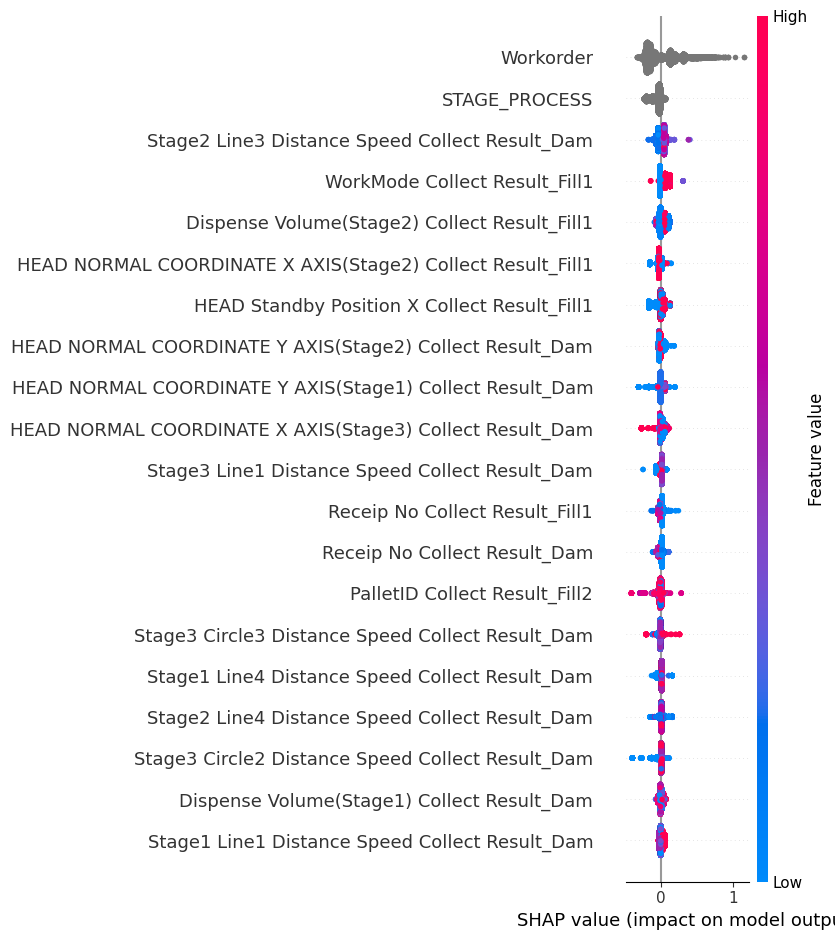

In [32]:
import shap

# SHAP 값 계산
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(X_test)

# SHAP 피처 중요도 시각화
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)